# Part 2

## This is a neural network that will perform text classification on our pre-processed data

In [1]:
import torch
from torch import (nn, optim)
from torch.utils.data import (Dataset, DataLoader, random_split)
from torchsummaryX import summary
import pandas as pd
import numpy as np
import warnings
import test_lib
from importlib import reload
from torch.nn import functional as F
from torchmetrics import Accuracy
import time
reload(test_lib)
warnings.filterwarnings('ignore')

## Load the dataset

In [2]:
train_dataset = torch.load('./train_dataset.npz')
test_dataset = torch.load('./test_dataset.npz')

print("Training dataset: %d" % len(train_dataset))
print("Test dataset: %d" % len(test_dataset))

Training dataset: 20000
Test dataset: 5000


## Load the vocabulary

In [3]:
vocab = torch.load('./vocab.pt')
print("There are %d tokens in vocabulary." % len(vocab))

There are 2000 tokens in vocabulary.


## Check data

In [4]:
x, y = train_dataset[128]
print("Review:", " ".join(vocab.lookup_tokens(x.numpy().tolist())))
print("Label:", y.item())

Review: i <unk> this movie despite its extremely low rating because i wanted to see how the crew manages to <unk> the presence of <unk> <unk> . as a matter of fact they didn t at least so its seems . some cameo appearance cut rather <unk> into the movie that s it this is what the <unk> of viewers think . however the surprise comes at the end and unfortunately then when probably most of the viewers have already <unk> this movie . i was also <unk> when i saw that the <unk> <unk> title of this movie means <unk>
Label: 1


## Model

In [5]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=len(vocab), embedding_dim=128)
        self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=2, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.4)
        self.mlp = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
      
        self.linear = nn.Linear(32,2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, (h, c) = self.lstm(x)
        x = self.dropout(c[0])
        x = self.mlp(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [6]:
model = MyModel()
dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
xs, targets = next(iter(dataloader))
model(xs).shape

torch.Size([128, 2])

## Training

In [7]:
def train(model: MyModel,
          train_dataset: Dataset,
          epochs: int, 
          max_batches=None) -> pd.DataFrame:
    
    train_loader = DataLoader(train_dataset, batch_size=max_batches, shuffle=True)
    accuracy = Accuracy(task='binary', num_classes=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.CrossEntropyLoss() 
    history = {
        'train_loss': [],
        'train_acc': [],
    }
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        
        start_time = time.time()
        
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            batch_loss = loss_fn(outputs, targets)
            batch_loss.backward()
            optimizer.step()
            
            train_loss += batch_loss.item()
            train_acc += accuracy(outputs.argmax(dim=1), targets).item()
        
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        end_time = time.time() 
        elapsed_time = end_time - start_time 
        
        print(f'Epoch {epoch+1}/{epochs} - ' f'Loss: {train_loss:.4f}, ' f'Accuracy: {train_acc:.4f}, ' f'Time: {elapsed_time:.2f}s')
    
    return pd.DataFrame(history)


    

In [8]:
# Train the model

model = MyModel()
hist = train(model, train_dataset, epochs=20, max_batches=500)

Epoch 1/20 - Loss: 0.6924, Accuracy: 0.5148, Time: 102.74s
Epoch 2/20 - Loss: 0.6876, Accuracy: 0.5478, Time: 113.43s
Epoch 3/20 - Loss: 0.6914, Accuracy: 0.5208, Time: 91.94s
Epoch 4/20 - Loss: 0.6907, Accuracy: 0.5293, Time: 92.11s
Epoch 5/20 - Loss: 0.6903, Accuracy: 0.5311, Time: 91.95s
Epoch 6/20 - Loss: 0.6885, Accuracy: 0.5400, Time: 97.31s
Epoch 7/20 - Loss: 0.6869, Accuracy: 0.5440, Time: 95.59s
Epoch 8/20 - Loss: 0.6712, Accuracy: 0.5851, Time: 90.94s
Epoch 9/20 - Loss: 0.6405, Accuracy: 0.6431, Time: 92.25s
Epoch 10/20 - Loss: 0.5942, Accuracy: 0.7023, Time: 95.08s
Epoch 11/20 - Loss: 0.5653, Accuracy: 0.7329, Time: 91.24s
Epoch 12/20 - Loss: 0.5403, Accuracy: 0.7669, Time: 91.81s
Epoch 13/20 - Loss: 0.5203, Accuracy: 0.7856, Time: 92.17s
Epoch 14/20 - Loss: 0.5101, Accuracy: 0.7965, Time: 91.34s
Epoch 15/20 - Loss: 0.4940, Accuracy: 0.8146, Time: 100.36s
Epoch 16/20 - Loss: 0.4876, Accuracy: 0.8208, Time: 90.92s
Epoch 17/20 - Loss: 0.4853, Accuracy: 0.8237, Time: 93.22s
Epo

In [9]:
# Verify dataframe columns

hist.columns

Index(['train_loss', 'train_acc'], dtype='object')

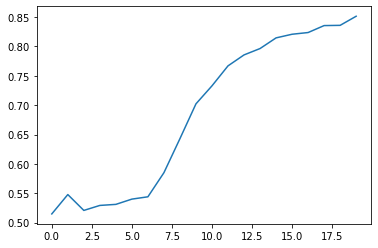

In [10]:
# Plot the training accuracy

hist.train_acc.plot.line();

In [11]:
# Save the entire model to disk

torch.save(model, 'mymodel.pt')

## Testing

The following code evaluates the model using `test_dataset`.

In [12]:
# Testing current model in memory

test_lib.test_saved_model(model)

Saved model has test accuracy = 78.70


In [13]:
# Testing saved model on disk

test_lib.test_saved_model()

Loading from mymodel.pt
Saved model has test accuracy = 78.46


# This model has an accuracy of approximately 79%